In [36]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay,
    classification_report, average_precision_score, precision_recall_curve
)
from joblib import dump

# Plot styling
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (9, 5)

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Load data
DATA_PATH = Path("/Users/dhwanil/Desktop/ONGOING PROJECTS/customer churn/data/churn.csv")
assert DATA_PATH.exists(), f"File not found: {DATA_PATH}"

df_raw = pd.read_csv(DATA_PATH)  # read once
df = df_raw.copy()               # working copy

print(df.shape)
df.head()

(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [37]:
# Inspect schema & missingness
display(df.info())
display(df.describe(include="all").T.head(20))
df.isna().sum().sort_values(ascending=False).head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,7043,7043,7590-VHVEG,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,7043,2,Male,3555,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,7043.0,NaN,NaN,NaN,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0
Partner,7043,2,No,3641,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,7043,2,No,4933,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tenure,7043.0,NaN,NaN,NaN,32.371149,24.559481,0.0,9.0,29.0,55.0,72.0
PhoneService,7043,2,Yes,6361,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MultipleLines,7043,3,No,3390,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InternetService,7043,3,Fiber optic,3096,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OnlineSecurity,7043,3,No,3498,NaN,NaN,NaN,NaN,NaN,NaN,NaN


customerID          0
DeviceProtection    0
TotalCharges        0
MonthlyCharges      0
PaymentMethod       0
PaperlessBilling    0
Contract            0
StreamingMovies     0
StreamingTV         0
TechSupport         0
dtype: int64

In [38]:
# Strip spaces in object columns and standardize text
for col in df.select_dtypes(include="object").columns:
    df[col] = df[col].astype(str).str.strip()

# Convert TotalCharges to numeric (known issue in Telco dataset)
if "TotalCharges" in df.columns:
    df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Map Churn Yes/No -> 1/0
if "Churn" in df.columns:
    df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0}).astype("Int64")

# Convert SeniorCitizen to a categorical-like string for clarity
if "SeniorCitizen" in df.columns and pd.api.types.is_numeric_dtype(df["SeniorCitizen"]):
    df["SeniorCitizen"] = df["SeniorCitizen"].map({1: "Yes", 0: "No"}).astype("string")

# Handle missing values lightly (keep for imputer in pipeline, but drop rows with missing target)
df = df[~df["Churn"].isna()].copy()

missing_summary = df.isna().sum().sort_values(ascending=False)
missing_summary.head(10)


TotalCharges        11
customerID           0
DeviceProtection     0
MonthlyCharges       0
PaymentMethod        0
PaperlessBilling     0
Contract             0
StreamingMovies      0
StreamingTV          0
TechSupport          0
dtype: int64

In [39]:
# Basic target distribution
churn_rate = df["Churn"].mean()
print(f"Dataset shape: {df.shape}, Churn rate: {churn_rate:.3f}")

# Create tenure bins for visualization
if "tenure" in df.columns:
    df["tenure_bin"] = pd.cut(
        df["tenure"],
        bins=[-1, 6, 12, 24, 36, 48, 60, df["tenure"].max()],
        labels=["0-6", "7-12", "13-24", "25-36", "37-48", "49-60", "60+"]
    )
df.head(3)


Dataset shape: (7043, 21), Churn rate: 0.265


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_bin
0,7590-VHVEG,Female,No,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0-6
1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.50,0,25-36
2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,0-6


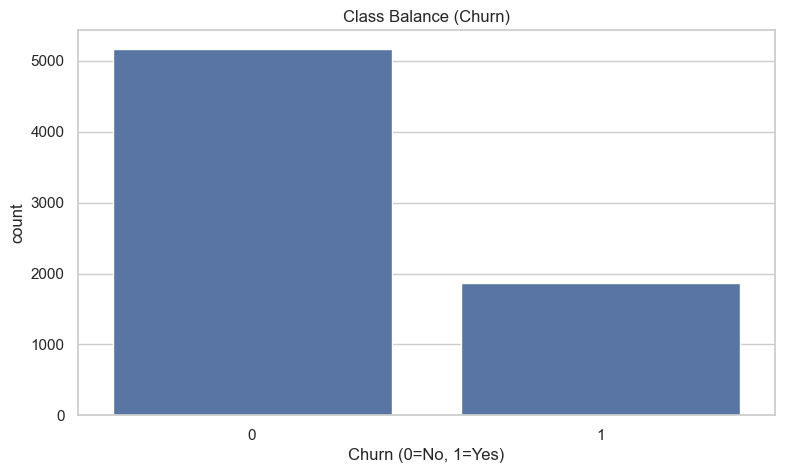

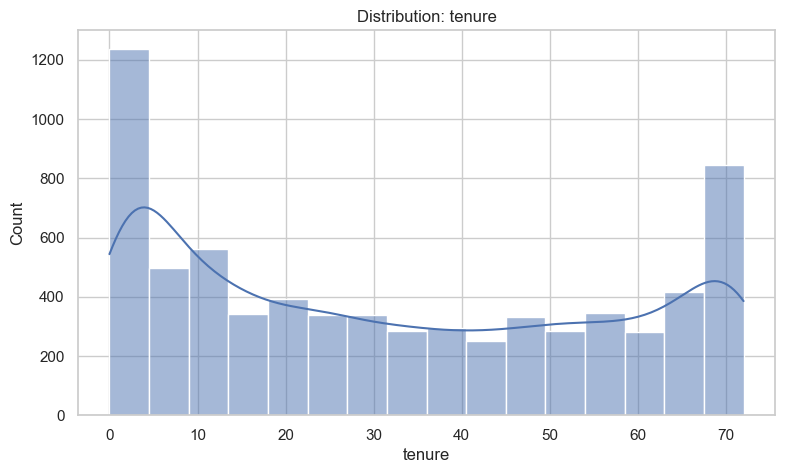

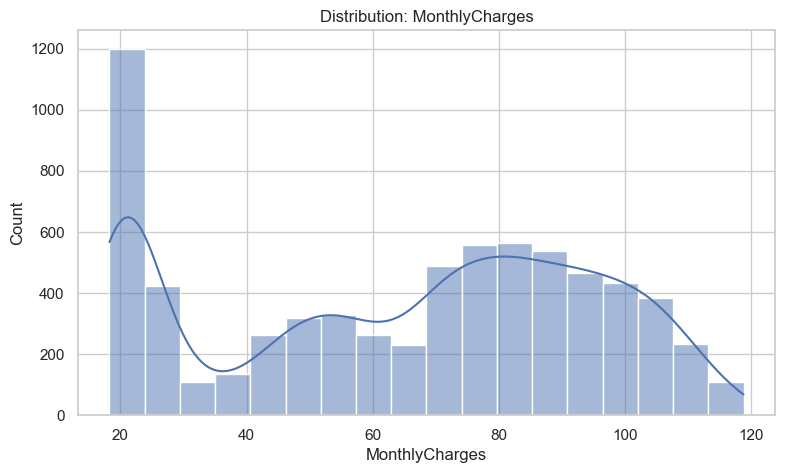

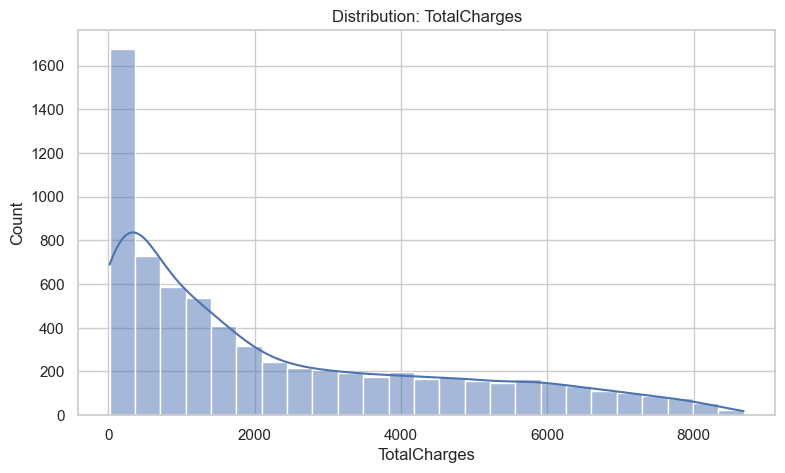

In [40]:
fig, ax = plt.subplots()
sns.countplot(data=df, x="Churn", ax=ax)
ax.set_title("Class Balance (Churn)")
ax.set_xlabel("Churn (0=No, 1=Yes)")
plt.show()

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != "Churn"]

for col in numeric_cols[:6]:  # show a few key ones
    fig, ax = plt.subplots()
    sns.histplot(df[col].dropna(), kde=True, ax=ax)
    ax.set_title(f"Distribution: {col}")
    plt.show()


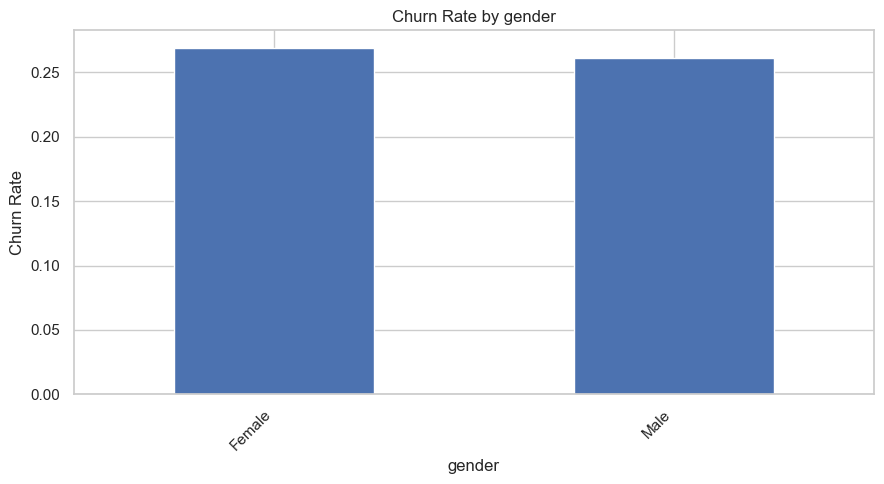

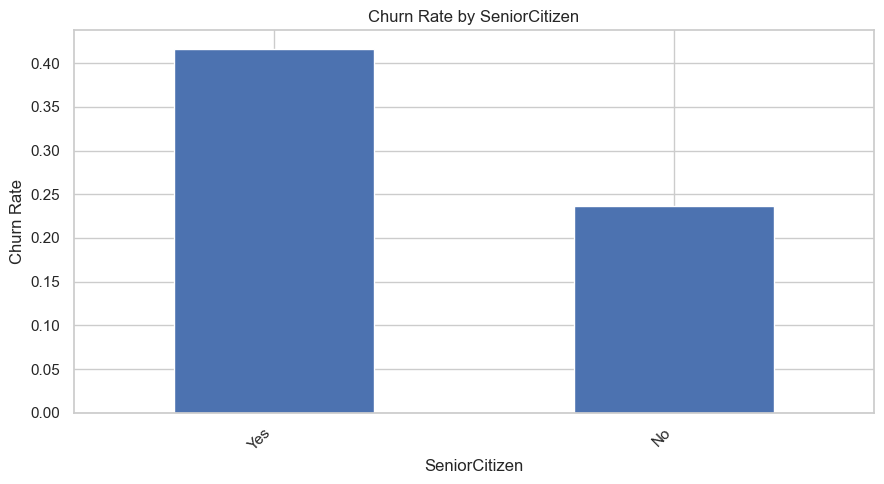

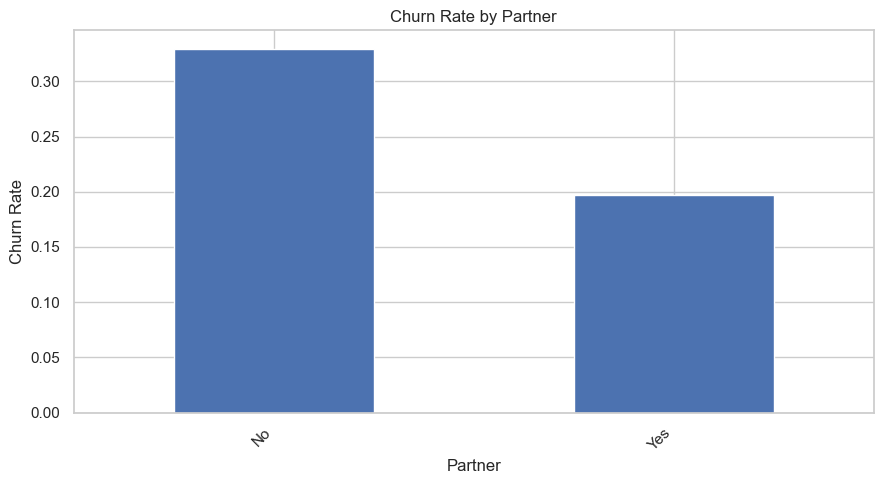

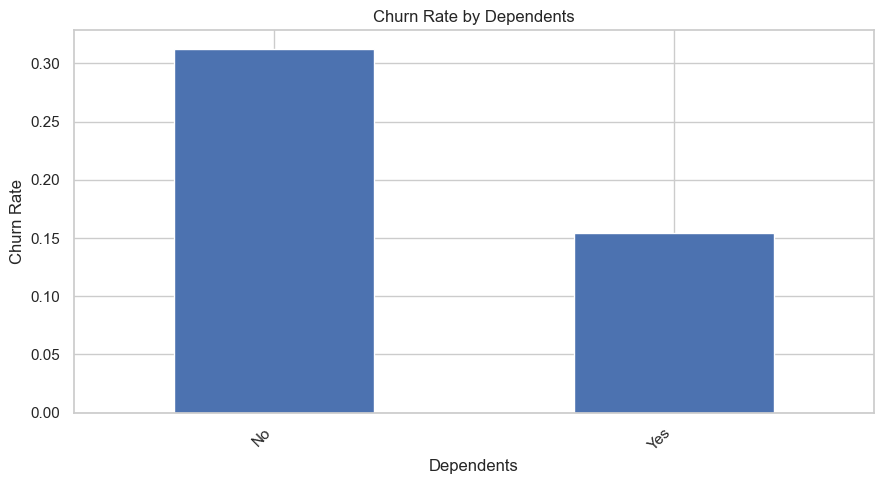

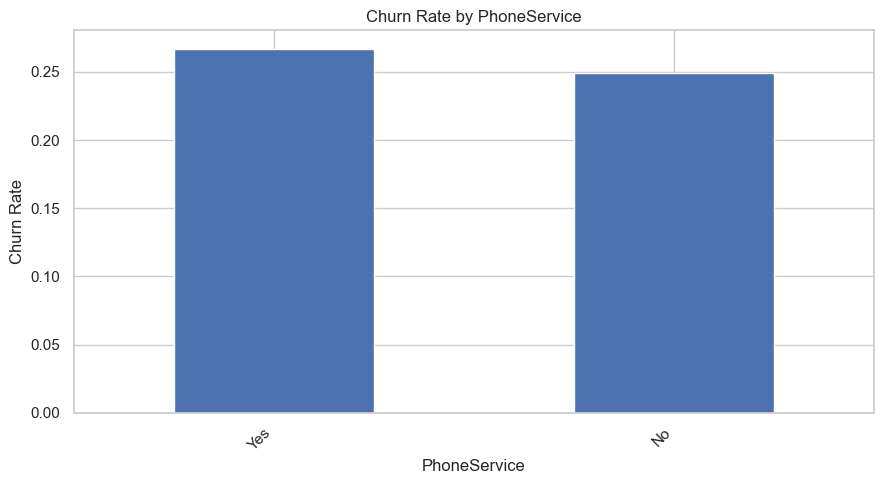

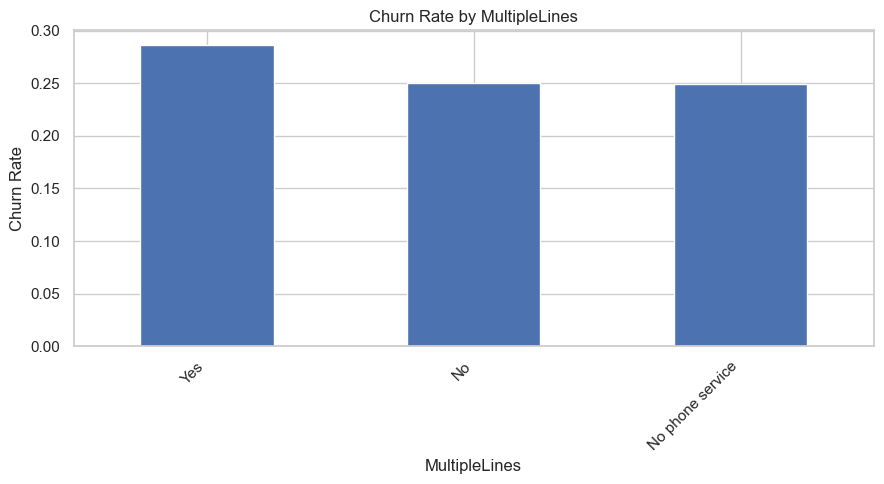

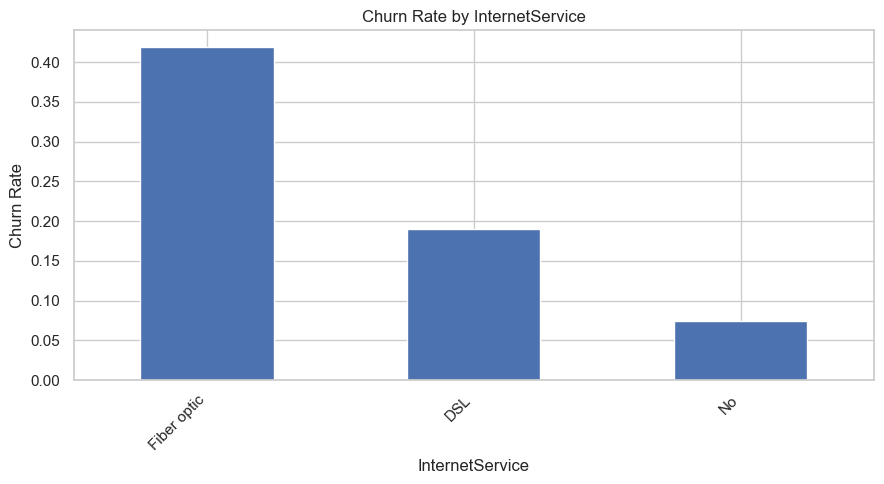

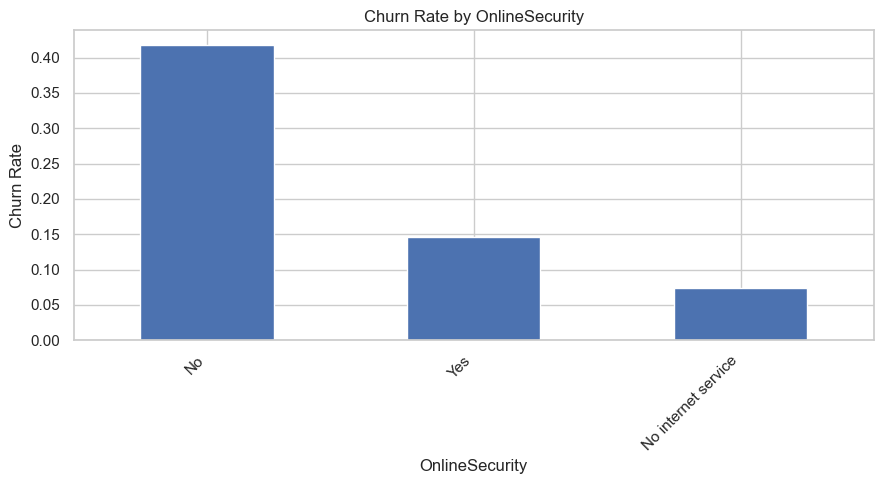

In [41]:
cat_cols = df.select_dtypes(include=["object", "string", "category"]).columns.tolist()
cat_cols = [c for c in cat_cols if c not in ("customerID", "Churn")]  # exclude id/target

def bar_churn_rate(col):
    tmp = df.groupby(col)["Churn"].mean().sort_values(ascending=False)
    ax = tmp.plot(kind="bar")
    ax.set_ylabel("Churn Rate")
    ax.set_title(f"Churn Rate by {col}")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

for col in cat_cols[:8]:  # preview top categorical drivers
    bar_churn_rate(col)


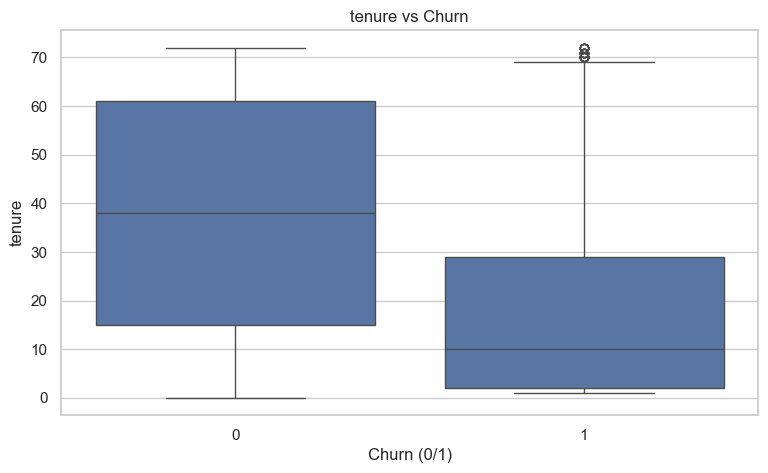

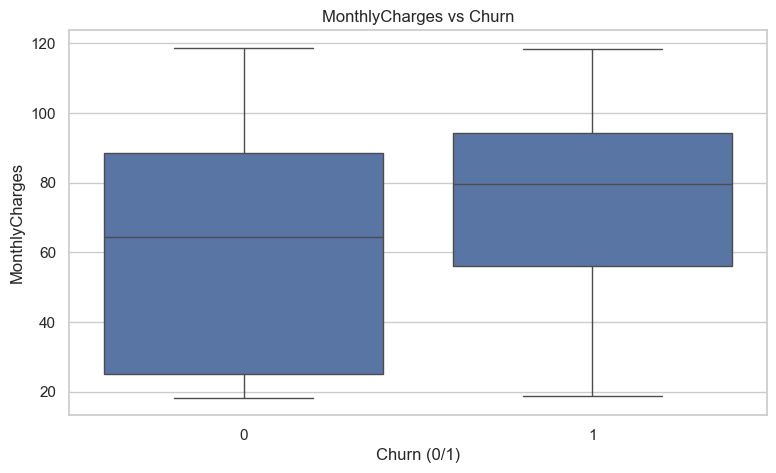

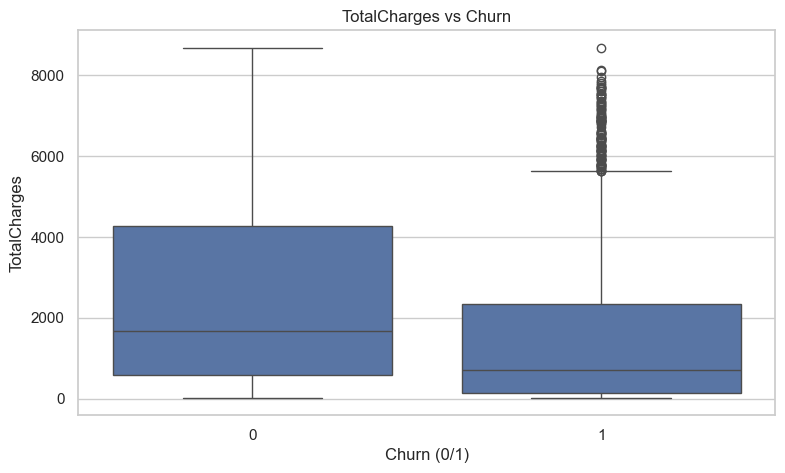

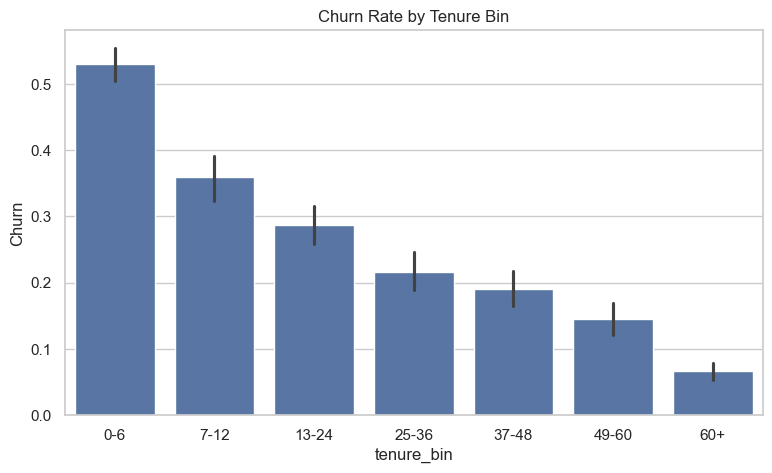

In [42]:
for col in numeric_cols[:6]:
    fig, ax = plt.subplots()
    sns.boxplot(data=df, x="Churn", y=col, ax=ax)
    ax.set_title(f"{col} vs Churn")
    ax.set_xlabel("Churn (0/1)")
    plt.show()

if "tenure_bin" in df.columns:
    fig, ax = plt.subplots()
    sns.barplot(data=df, x="tenure_bin", y="Churn", estimator=np.mean, ax=ax)
    ax.set_title("Churn Rate by Tenure Bin")
    plt.xticks(rotation=0)
    plt.show()


In [43]:
target = "Churn"
features = [c for c in df.columns if c not in [target, "customerID"]]

X = df[features].copy()
y = df[target].astype(int).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

X_train.shape, X_test.shape

((5634, 20), (1409, 20))

In [44]:
num_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X_train.select_dtypes(include=["object", "string", "category"]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=True, with_std=True))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features),
    ],
    remainder="drop"
)

print("Numeric:", num_features[:10], "...")
print("Categorical:", cat_features[:10], "...")


Numeric: ['tenure', 'MonthlyCharges', 'TotalCharges'] ...
Categorical: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection'] ...


In [45]:
log_reg = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", LogisticRegression(max_iter=500, n_jobs=None, random_state=RANDOM_STATE))
])

log_reg.fit(X_train, y_train)

y_pred_lr = log_reg.predict(X_test)
y_proba_lr = log_reg.predict_proba(X_test)[:, 1]

metrics_lr = {
    "accuracy": accuracy_score(y_test, y_pred_lr),
    "precision": precision_score(y_test, y_pred_lr, zero_division=0),
    "recall": recall_score(y_test, y_pred_lr),
    "f1": f1_score(y_test, y_pred_lr),
    "roc_auc": roc_auc_score(y_test, y_proba_lr),
    "avg_precision": average_precision_score(y_test, y_proba_lr)
}
metrics_lr


{'accuracy': 0.8026969481902059,
 'precision': 0.66,
 'recall': 0.5294117647058824,
 'f1': 0.5875370919881305,
 'roc_auc': 0.845056705159007,
 'avg_precision': 0.6515463050087926}

In [46]:
rf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

metrics_rf = {
    "accuracy": accuracy_score(y_test, y_pred_rf),
    "precision": precision_score(y_test, y_pred_rf, zero_division=0),
    "recall": recall_score(y_test, y_pred_rf),
    "f1": f1_score(y_test, y_pred_rf),
    "roc_auc": roc_auc_score(y_test, y_proba_rf),
    "avg_precision": average_precision_score(y_test, y_proba_rf)
}
metrics_rf

{'accuracy': 0.7849538679914834,
 'precision': 0.6195286195286195,
 'recall': 0.4919786096256685,
 'f1': 0.5484351713859911,
 'roc_auc': 0.8233524503345476,
 'avg_precision': 0.6128710274083435}

In [47]:
metrics_df = pd.DataFrame([metrics_lr, metrics_rf], index=["Logistic Regression", "Random Forest"])
metrics_df.sort_values("roc_auc", ascending=False)

,accuracy,precision,recall,f1,roc_auc,avg_precision
Logistic Regression,0.802697,0.660000,0.529412,0.587537,0.845057,0.651546
Random Forest,0.784954,0.619529,0.491979,0.548435,0.823352,0.612871


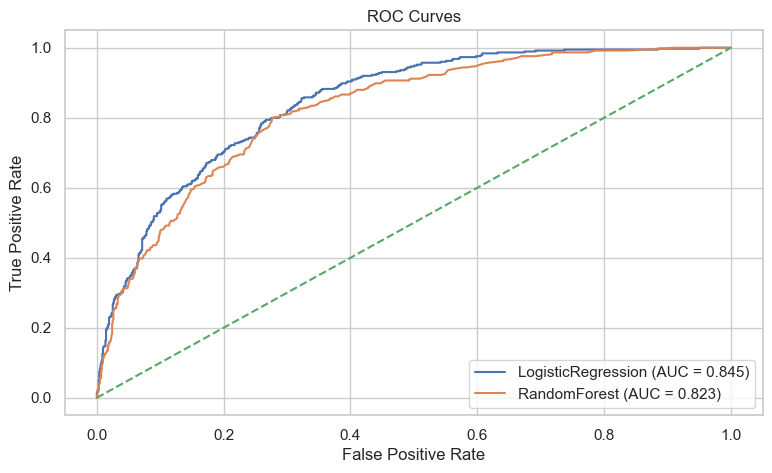

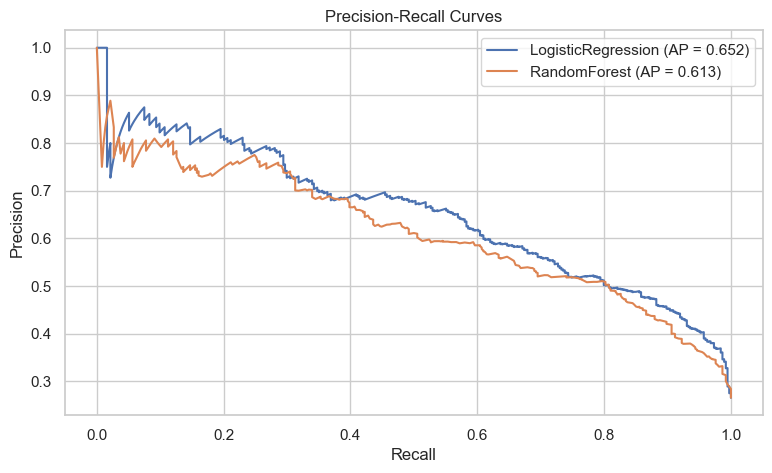

In [48]:
fig, ax = plt.subplots()
for name, y_score in [("LogisticRegression", y_proba_lr), ("RandomForest", y_proba_rf)]:
    fpr, tpr, _ = roc_curve(y_test, y_score)
    ax.plot(fpr, tpr, label=f"{name} (AUC = {auc(fpr, tpr):.3f})")
ax.plot([0, 1], [0, 1], linestyle="--")
ax.set_title("ROC Curves")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend()
plt.show()

fig, ax = plt.subplots()
for name, y_score in [("LogisticRegression", y_proba_lr), ("RandomForest", y_proba_rf)]:
    prec, rec, _ = precision_recall_curve(y_test, y_score)
    ax.plot(rec, prec, label=f"{name} (AP = {average_precision_score(y_test, y_score):.3f})")
ax.set_title("Precision-Recall Curves")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.legend()
plt.show()


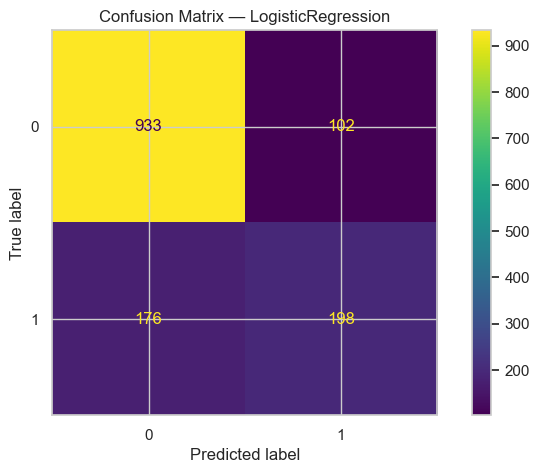

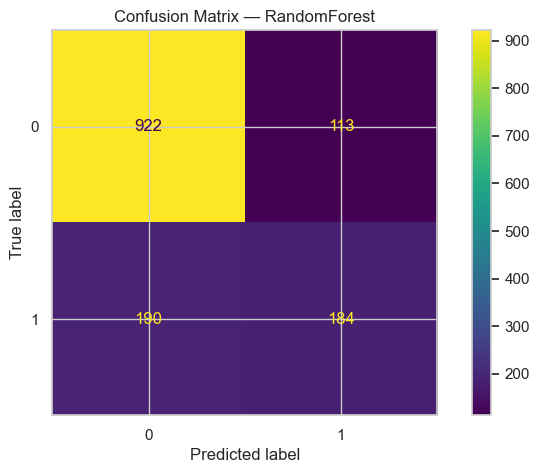

In [49]:
for name, y_pred in [("LogisticRegression", y_pred_lr), ("RandomForest", y_pred_rf)]:
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(values_format="d")
    plt.title(f"Confusion Matrix — {name}")
    plt.show()


In [50]:
print("Logistic Regression\n", classification_report(y_test, y_pred_lr, digits=3))
print("\nRandom Forest\n", classification_report(y_test, y_pred_rf, digits=3))


Logistic Regression
               precision    recall  f1-score   support

           0      0.841     0.901     0.870      1035
           1      0.660     0.529     0.588       374

    accuracy                          0.803      1409
   macro avg      0.751     0.715     0.729      1409
weighted avg      0.793     0.803     0.795      1409


Random Forest
               precision    recall  f1-score   support

           0      0.829     0.891     0.859      1035
           1      0.620     0.492     0.548       374

    accuracy                          0.785      1409
   macro avg      0.724     0.691     0.704      1409
weighted avg      0.773     0.785     0.776      1409



In [51]:
# Extract feature names from the ColumnTransformer
ohe = log_reg.named_steps["preprocess"].named_transformers_["cat"].named_steps["onehot"]
ohe_features = list(ohe.get_feature_names_out(cat_features))
final_feature_names = list(num_features) + ohe_features
len(final_feature_names), final_feature_names[:10]


(53,
 ['tenure',
  'MonthlyCharges',
  'TotalCharges',
  'gender_Female',
  'gender_Male',
  'SeniorCitizen_No',
  'SeniorCitizen_Yes',
  'Partner_No',
  'Partner_Yes',
  'Dependents_No'])

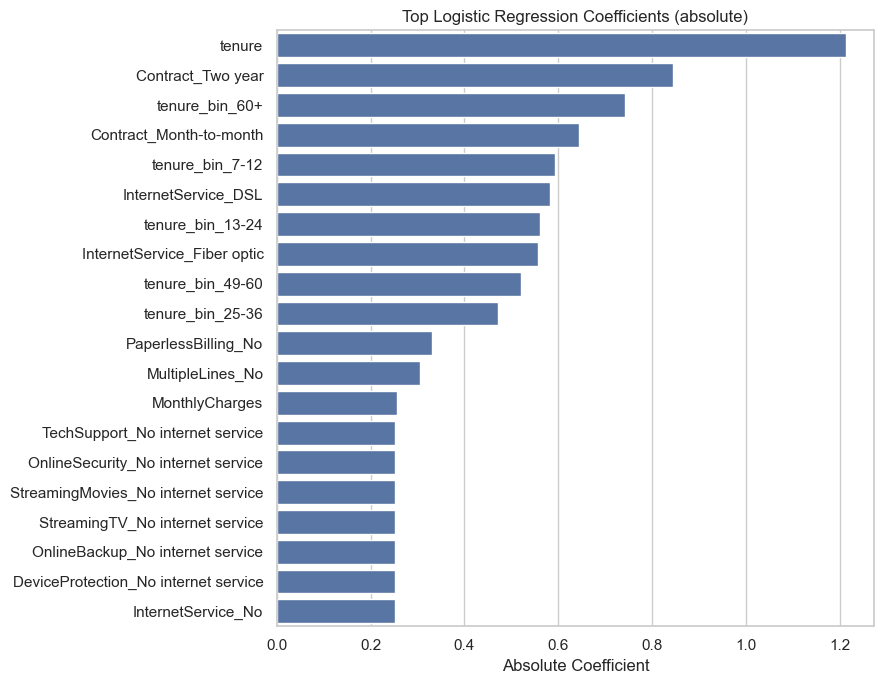

,feature,coef,abs_coef
0,tenure,-1.212520,1.212520
39,Contract_Two year,-0.844967,0.844967
51,tenure_bin_60+,0.742643,0.742643
37,Contract_Month-to-month,0.644855,0.644855
52,tenure_bin_7-12,-0.592318,0.592318
16,InternetService_DSL,-0.582536,0.582536
47,tenure_bin_13-24,-0.560624,0.560624
17,InternetService_Fiber optic,0.557568,0.557568
50,tenure_bin_49-60,0.521379,0.521379
48,tenure_bin_25-36,-0.471249,0.471249


In [52]:
coef = log_reg.named_steps["clf"].coef_.ravel()
imp_df_lr = pd.DataFrame({"feature": final_feature_names, "coef": coef})
imp_df_lr["abs_coef"] = imp_df_lr["coef"].abs()
top_lr = imp_df_lr.sort_values("abs_coef", ascending=False).head(20)

fig, ax = plt.subplots(figsize=(9, 7))
sns.barplot(data=top_lr, y="feature", x="abs_coef", ax=ax)
ax.set_title("Top Logistic Regression Coefficients (absolute)")
ax.set_xlabel("Absolute Coefficient")
ax.set_ylabel("")
plt.tight_layout()
plt.show()

top_lr.head(10)


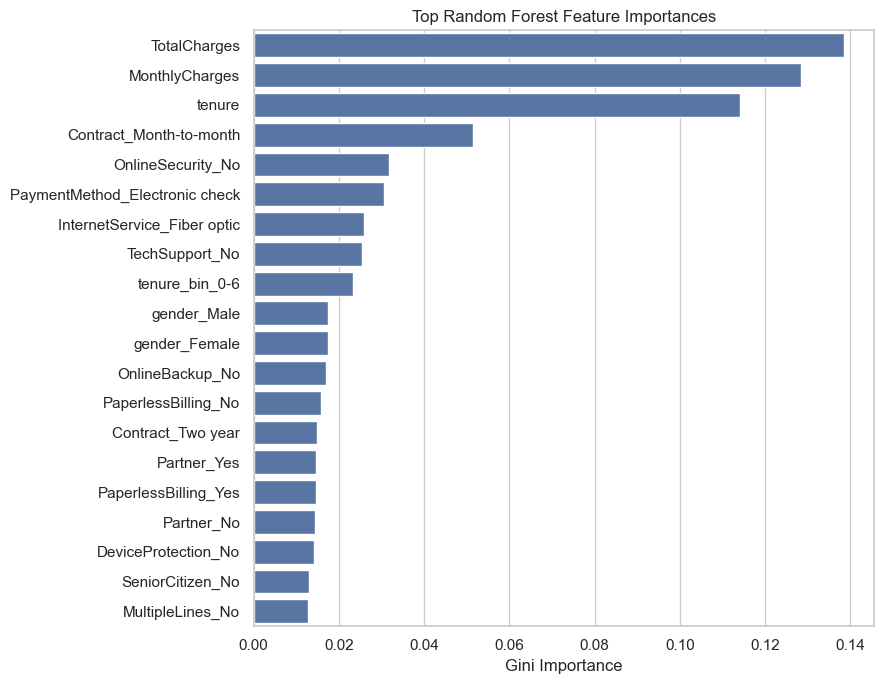

,feature,importance
2,TotalCharges,0.138607
1,MonthlyCharges,0.128509
0,tenure,0.114004
37,Contract_Month-to-month,0.051404
19,OnlineSecurity_No,0.031669
44,PaymentMethod_Electronic check,0.030518
17,InternetService_Fiber optic,0.025889
28,TechSupport_No,0.025462
46,tenure_bin_0-6,0.023371
4,gender_Male,0.017455


In [53]:
rf_feats = rf.named_steps["clf"].feature_importances_
imp_df_rf = pd.DataFrame({"feature": final_feature_names, "importance": rf_feats})
top_rf = imp_df_rf.sort_values("importance", ascending=False).head(20)

fig, ax = plt.subplots(figsize=(9, 7))
sns.barplot(data=top_rf, y="feature", x="importance", ax=ax)
ax.set_title("Top Random Forest Feature Importances")
ax.set_xlabel("Gini Importance")
ax.set_ylabel("")
plt.tight_layout()
plt.show()

top_rf.head(10)


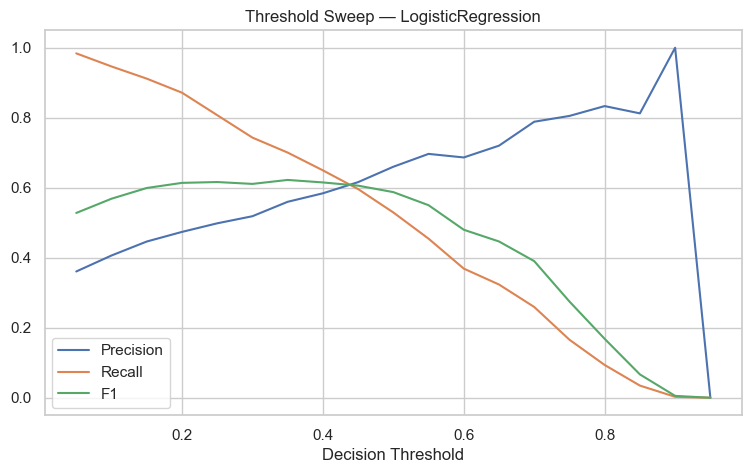

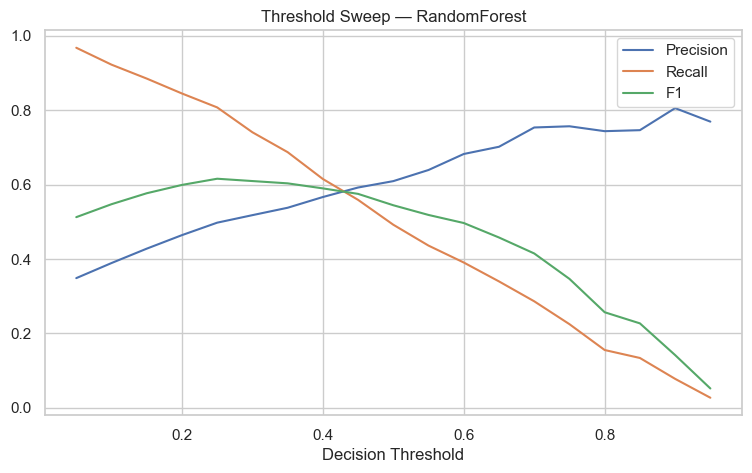

,threshold,precision,recall,f1
0,0.05,0.360784,0.983957,0.527977
1,0.10,0.406429,0.946524,0.568675
2,0.15,0.446335,0.911765,0.599297
3,0.20,0.473837,0.871658,0.613936
4,0.25,0.498350,0.807487,0.616327


In [54]:
def plot_threshold_sweep(y_true, y_scores, model_name="Model"):
    thr = np.linspace(0.05, 0.95, 19)
    rows = []
    for t in thr:
        y_hat = (y_scores >= t).astype(int)
        rows.append({
            "threshold": t,
            "precision": precision_score(y_true, y_hat, zero_division=0),
            "recall": recall_score(y_true, y_hat),
            "f1": f1_score(y_true, y_hat)
        })
    d = pd.DataFrame(rows)
    fig, ax = plt.subplots()
    ax.plot(d["threshold"], d["precision"], label="Precision")
    ax.plot(d["threshold"], d["recall"], label="Recall")
    ax.plot(d["threshold"], d["f1"], label="F1")
    ax.set_title(f"Threshold Sweep — {model_name}")
    ax.set_xlabel("Decision Threshold")
    ax.legend()
    plt.show()
    return d

thr_lr = plot_threshold_sweep(y_test, y_proba_lr, "LogisticRegression")
thr_rf = plot_threshold_sweep(y_test, y_proba_rf, "RandomForest")

thr_lr.head()
